In [1]:
%load_ext autoreload
%autoreload 2

In [311]:
from data_models.basic import Tabular, LOCOData
from models.basic import SVM, LogisticReg, RandForestRegressor
from conformal_prediction.basic import SimpleConformal, SplitConformal, SplitConformalBetter
from explainable_models.variable_importance.LOCO import SimpleLOCO, plot_ci, OldConformalLOCO, NewConformalLOCO
from sklearn.ensemble import RandomForestRegressor

In [62]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read Data
wineqt = Tabular(data_path='data\WineQT.csv', split_percentages=[0.70, 0.20, 0.10])
wineqt.X_y_split(y='quality')

In [4]:
# Train model and evaluate performance
# svm_model = SVM(data_model=wineqt, probability=True, verbose=True)
logistic_model = LogisticReg(max_iter=5000)

In [5]:
fitted_model = logistic_model.fit(train_X=wineqt.train_data_X, 
                                  train_y=wineqt.train_data_y)

C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [6]:
acc, cm = logistic_model.evaluate(fitted_model, test_X=wineqt.test_data_X, 
                                  test_y=wineqt.test_data_y)
print(acc)
print(cm)

0.5478260869565217
[[ 0  0  2  0  0  0]
 [ 0  0  1  0  0  0]
 [ 0  0 30 10  1  0]
 [ 0  0 20 30  6  0]
 [ 0  0  1 10  3  0]
 [ 0  0  0  1  0  0]]


In [7]:
order_dict = {3: 0,
              4: 1,
              5: 2,
              6: 3,
              7: 4,
              8: 5}

conformal = SimpleConformal(wineqt, fitted_model, alpha=0.7, class_order=order_dict)

In [8]:
lambda_conformal = conformal.calibrate()
pred = conformal.predict(data=wineqt.test_data_X, lambda_conformal=lambda_conformal)

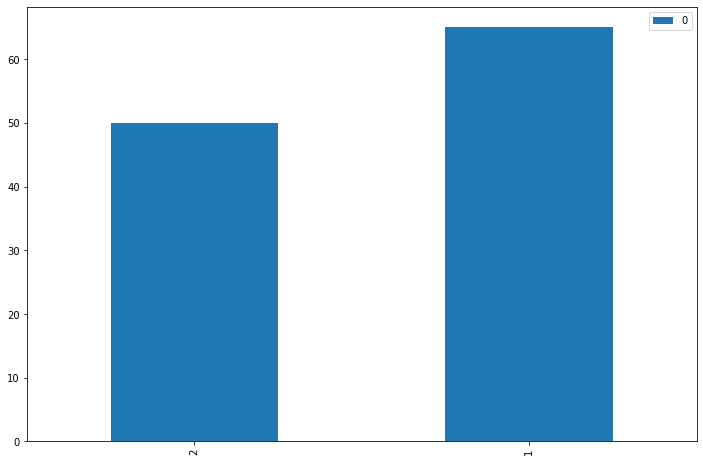

In [9]:
coverage, size = conformal.evaluate(true_data=wineqt.test_data_y, pred=pred, plot=True)

In [10]:
print(coverage)
print(size)

0.7304347826086957
165


# Variable Importance

### Simple LOCO

In [59]:
loco = SimpleLOCO(model=logistic_model, train_data=wineqt.train_data, y_feature='quality')

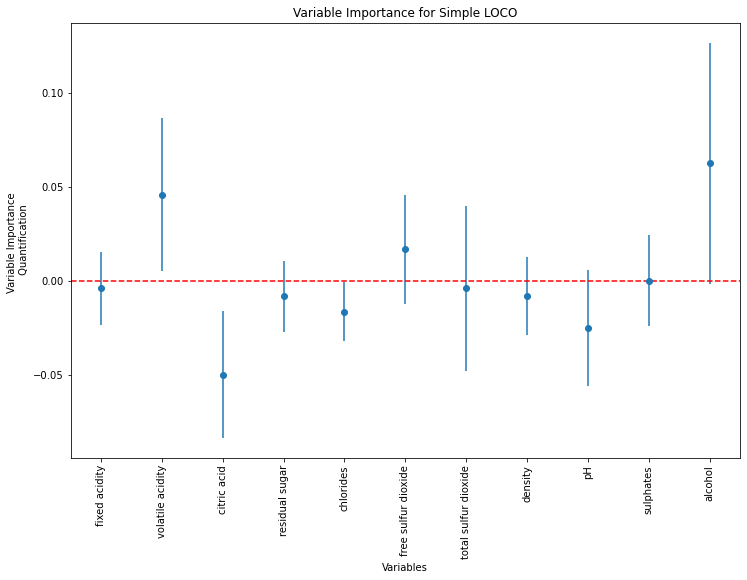

In [113]:
x = []
y = []
yerr = []
for var in wineqt.train_data.columns.tolist()[:-2]:
    feature_importance, ci = loco.run_loco(variable=var, prop=0.7, loss_type='mean', alpha=0.05, bootstrap=200)
    x.append(var)
    y.append(feature_importance)
    yerr.append(ci)

plot_ci(x=x, y=y, yerr=yerr, title='Variable Importance for Simple LOCO')

# Replicate LOCO paper experiment

In [144]:
locodata = LOCOData(n=3000)
locodata.X_y_split(y='Y')

In [150]:
random_foreest = RandForestRegressor()
fitted_logistic_loco = random_foreest.fit(locodata.train_data_X, locodata.train_data_y)

In [189]:
split_conformal = SplitConformal(data_model=locodata, model=random_foreest, alpha=0.1)
lambda_conformal = split_conformal.calibrate(residual='normal', y_feature='Y')
conformal_set = split_conformal.predict(data=locodata.test_data_X, lambda_conformal=lambda_conformal)
coverage, size = split_conformal.evaluate(pred=conformal_set, true_data=locodata.test_data_y)

In [257]:
loco_conformal = OldConformalLOCO(data_model=locodata, conformal_model=split_conformal)

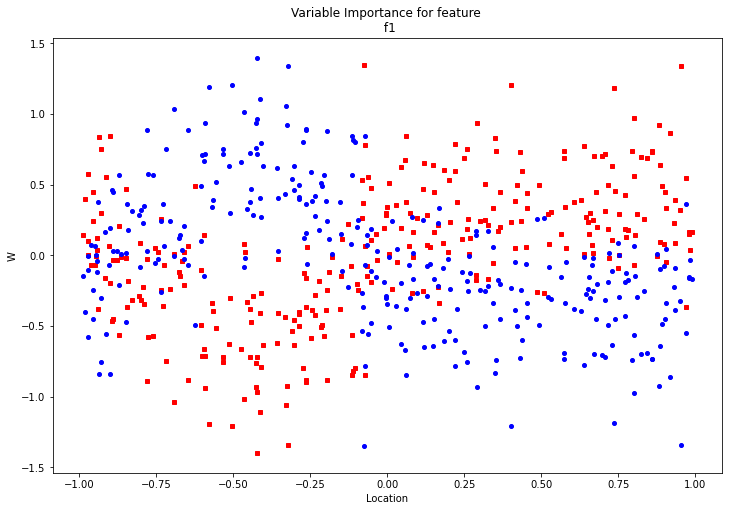

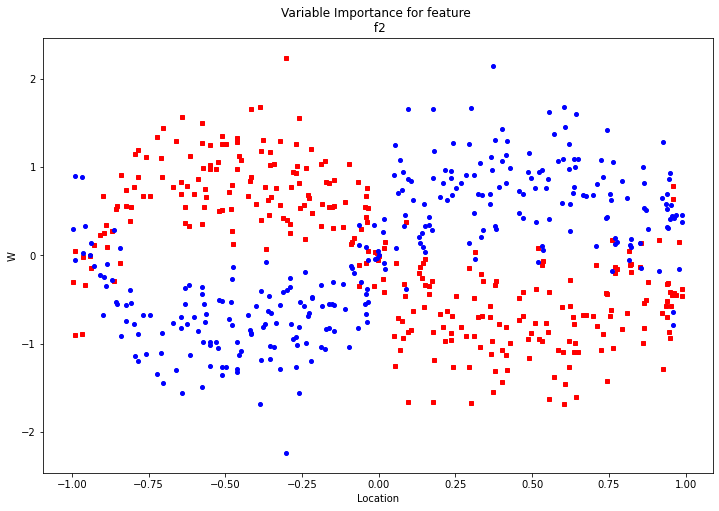

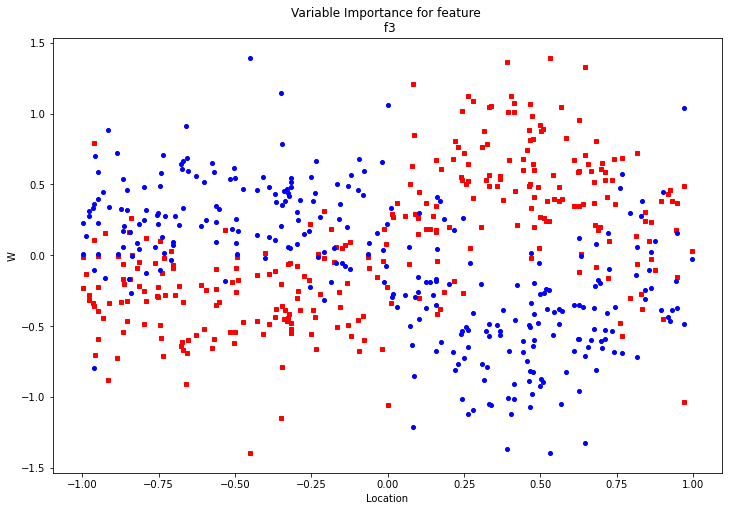

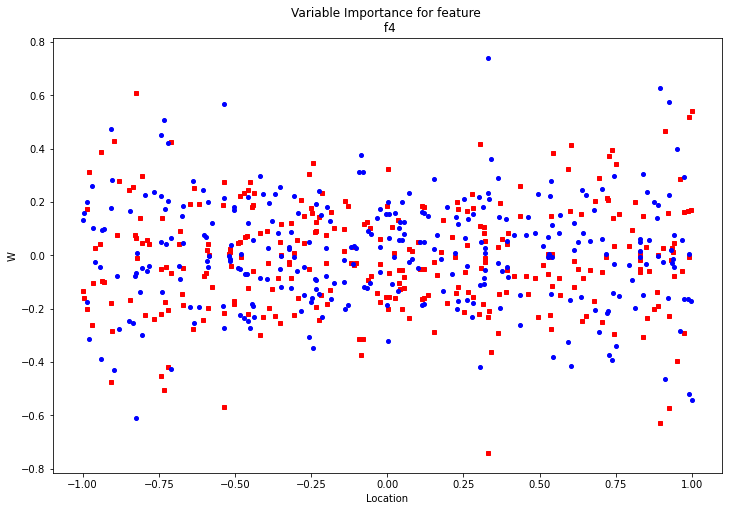

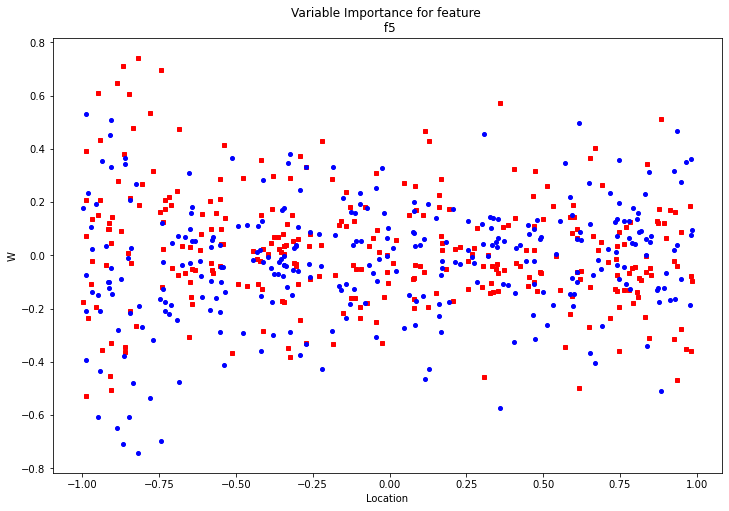

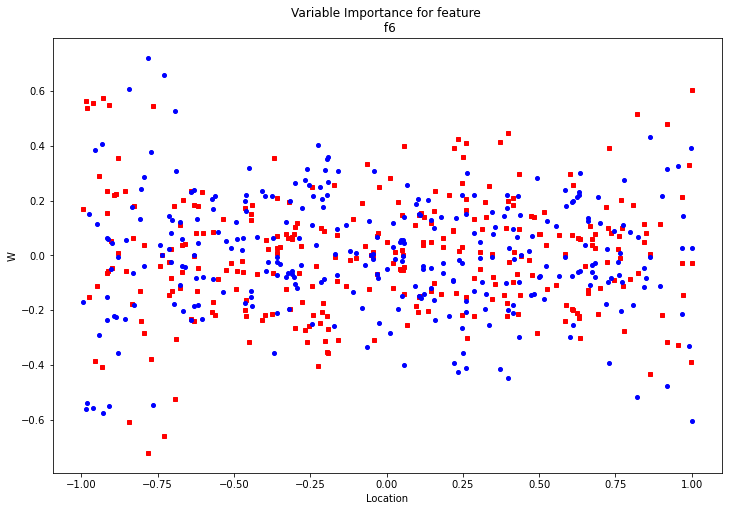

In [261]:
for var in locodata.train_data_X.columns:
    W_j = loco_conformal.run(model=RandomForestRegressor(), 
                             variable=var, lambda_conformal=lambda_conformal, 
                             loss_type='normal', plot=True)

# Own Variable Importance

So the idea is to implement the following:

1. Estimate the model on the complete training data
2. Find a conformal prediction set (i.e. calibrate) on the calibration data
3. Find an alternative conformal prediction set for the same calibration data but removing the j-th feature
4. Construct both conformal sets (hoping that the alternative conformal prediction is larger)
5. Compute the difference between these two conformal sets

In [375]:
locodata = LOCOData(n=10000)
locodata.X_y_split(y='Y')

In [376]:
random_forest = RandomForestRegressor()
random_forest.fit(locodata.train_data_X, locodata.train_data_y)

RandomForestRegressor()

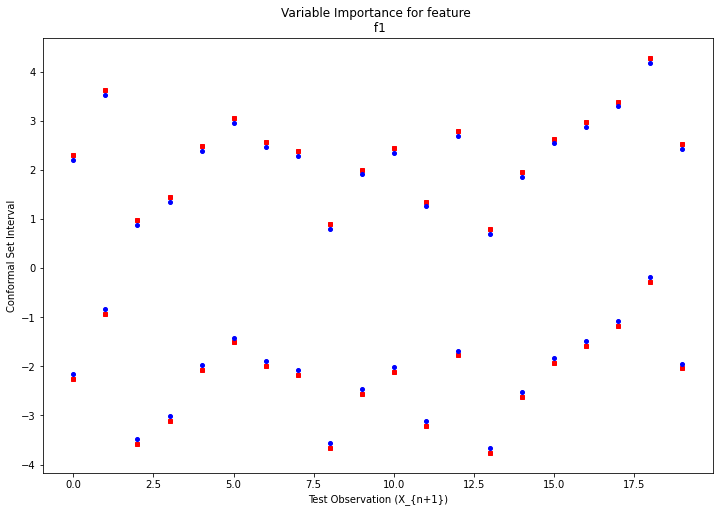

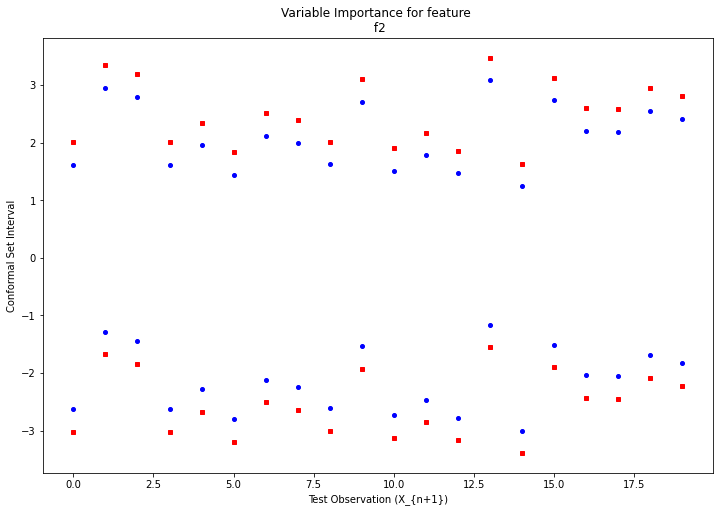

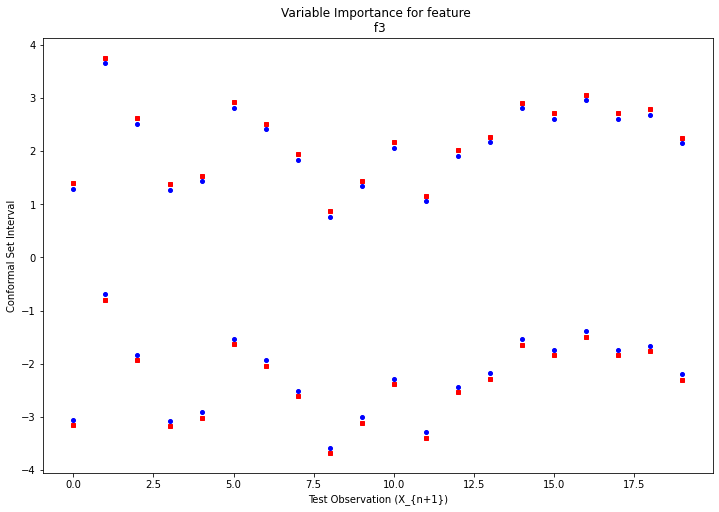

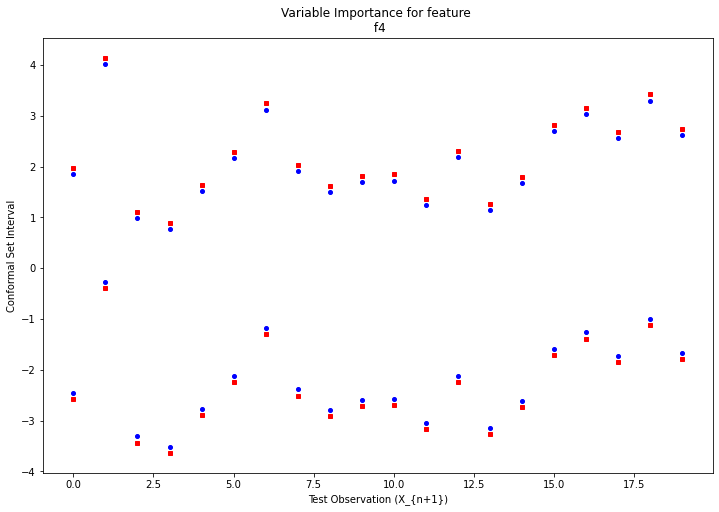

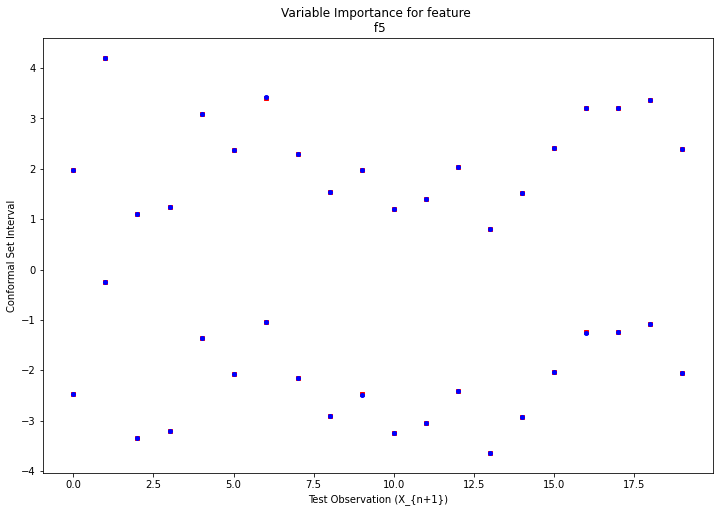

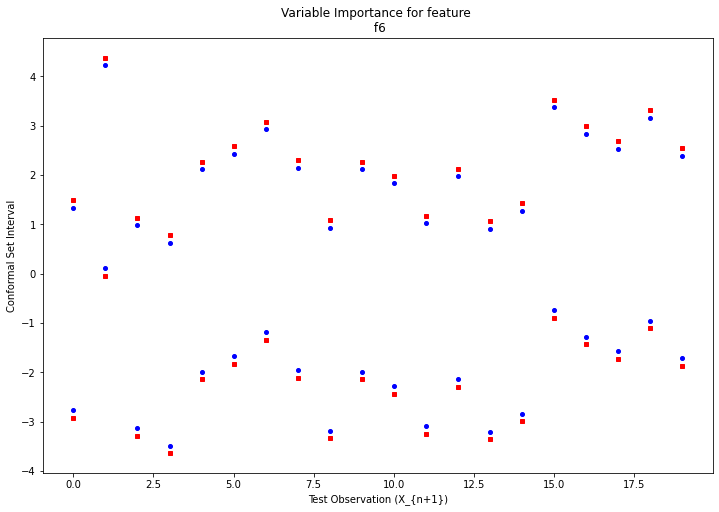

In [443]:
# Blue interval: Conformal Set with all the features
# Red interval: Conformal Set removing one feature
conformal_predictor = SplitConformalBetter(alpha=0.05)

for var in locodata.train_data_X.columns:
    newconformalexplainer = NewConformalLOCO(conformal_predictor=conformal_predictor)
    conformal_set_all, conformal_set_j = newconformalexplainer.run(model=random_forest, data_X_calibrate=locodata.calib_data_X, data_y_calibrate=locodata.calib_data_y, 
                              data_X_test=locodata.test_data_X, 
                              variable=var, loss_type='IoU', plot=20, test_same_dist=True)

In [365]:
eval = newconformalexplainer.evaluate(conformal_set=conformal_set_all, true_y=locodata.test_data_y)

0.958
4278.5599835583325
0.955
4543.310748991562


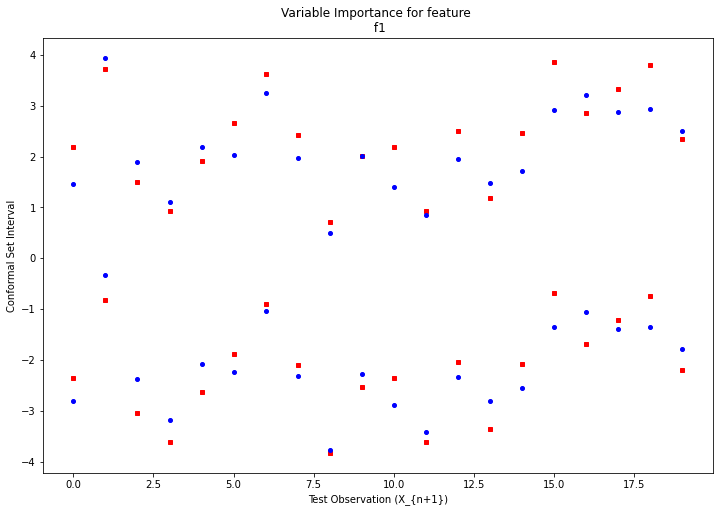

0.962
4426.787548419844
0.951
4988.89400653808


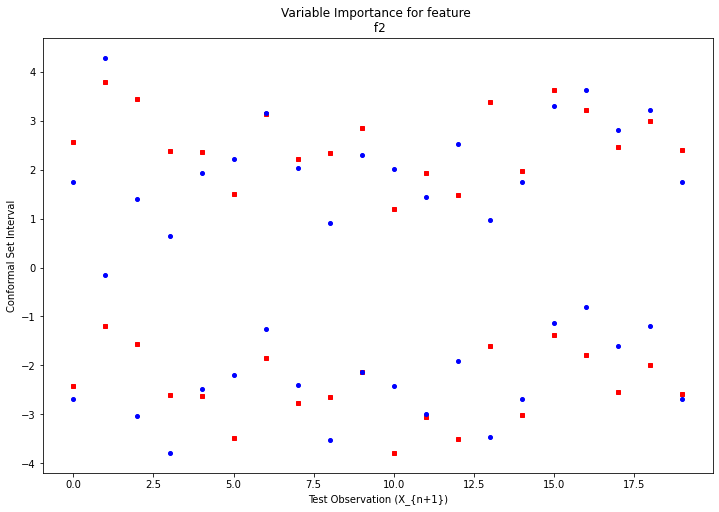

0.959
4442.021851687138
0.97
4639.63123174833


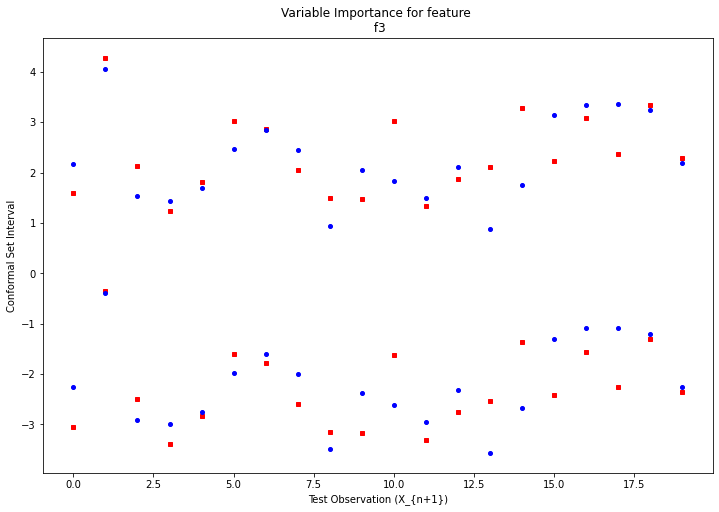

0.939
4009.532990912276
0.962
4381.1900386750685


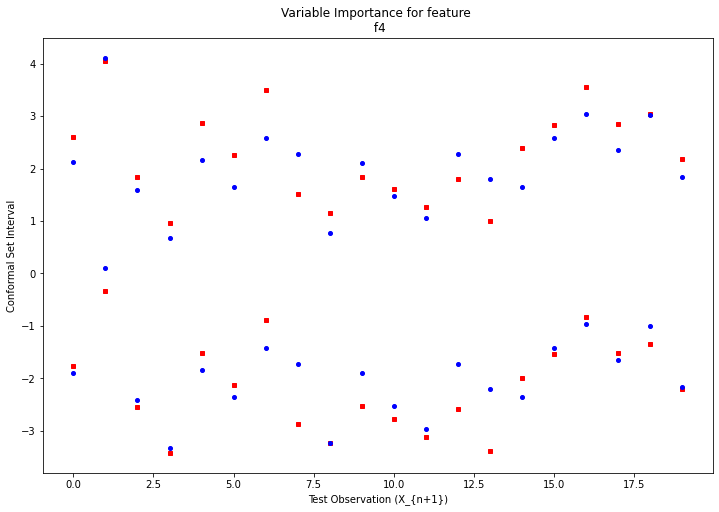

0.947
4252.723671481032
0.95
4291.996347644294


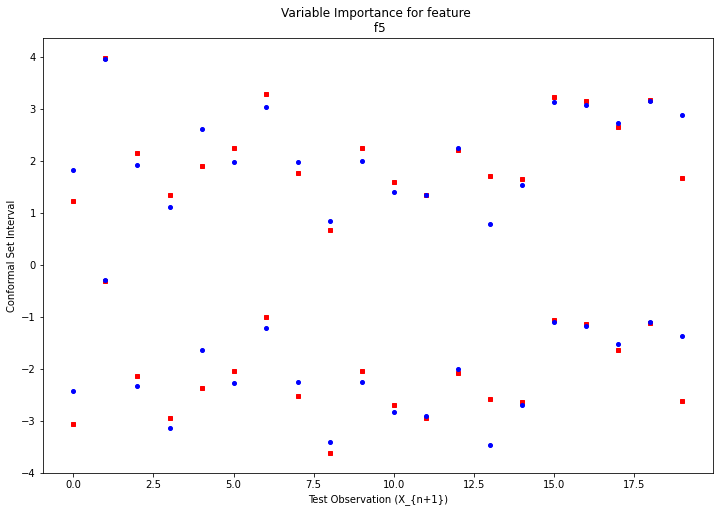

0.956
4202.903857114038
0.958
4355.782918318743


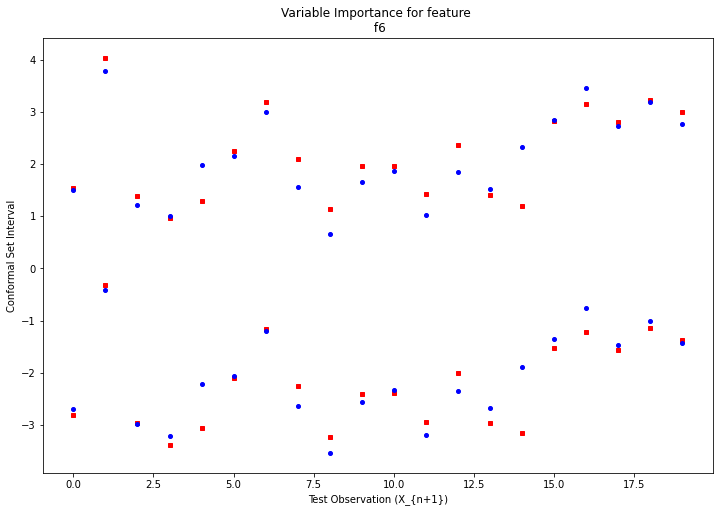

In [446]:
for variable in locodata.calib_data_X.columns:

    conformal_predictor = SplitConformalBetter(alpha=0.05)
    lambda_all, model_all = conformal_predictor.calibrate(data_X=locodata.calib_data_X, data_y=locodata.calib_data_y, model=RandomForestRegressor())
    pred_all = conformal_predictor.predict(locodata.test_data_X, model=model_all, lambda_conformal=lambda_all)
    cov, size = conformal_predictor.evaluate(pred_all, locodata.test_data_y)
    print(cov)
    print(size)
    import copy
    conformal_predictor_j = SplitConformalBetter(alpha=0.05)

    data_X_j = copy.copy(locodata.calib_data_X)
    data_X_j[variable] = 0
    data_X_test_j = copy.copy(locodata.test_data_X)
    data_X_test_j[variable] = 0

    lambda_j, model_j = conformal_predictor_j.calibrate(data_X=data_X_j, data_y=locodata.calib_data_y, model=RandomForestRegressor())
    pred_j = conformal_predictor_j.predict(data_X_test_j, model=model_j, lambda_conformal=lambda_j)
    cov_j, size_j = conformal_predictor_j.evaluate(pred_j, locodata.test_data_y)
    print(cov_j)
    print(size_j)

    plot = 20
    if plot:
        y_j = pred_j[:plot]
        y_all = pred_all[:plot]
        x = range(len(y_j))

        plt.figure(figsize=(12, 8))
        plt.plot(x, [i for (i,j) in y_j], 'rs', markersize = 4)
        plt.plot(x, [j for (i,j) in y_j], 'rs', markersize = 4)
        plt.plot(x, [i for (i,j) in y_all], 'bo', markersize = 4)
        plt.plot(x, [j for (i,j) in y_all], 'bo', markersize = 4)
        #plt.plot((x,x),([i for (i,j) in y], [j for (i,j) in y]),c='black')

        plt.xlabel('Test Observation (X_{n+1})')
        plt.ylabel('Conformal Set Interval')
        plt.title('Variable Importance for feature \n ' + variable)
        plt.show()